[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/01_bandits.ipynb)

# CliffWalking

In [3]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [4]:
env = gym.make("CliffWalking-v0")
n_states = env.observation_space.n
n_actions = env.action_space.n

print("Estados:", n_states)
print("Acciones:", n_actions)


Estados: 48
Acciones: 4


## Implementaci√≥n incremental

In [5]:
def q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                target = reward  # No hay estado futuro
            else:
                target = reward + gamma * np.max(Q[next_state])
            
            Q[state, action] += alpha * (target - Q[state, action])
            total_reward += reward
            state = next_state

        rewards.append(total_reward)
    return Q, rewards

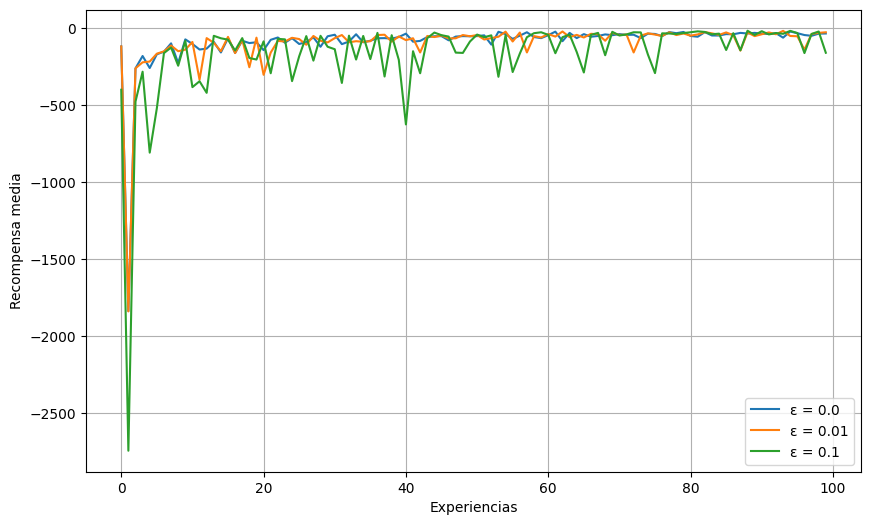

In [6]:
epsilons = [0.0, 0.01, 0.1]

# Ejecutar y graficar
plt.figure(figsize=(10, 6))

for eps in epsilons:
    Q, rewards = q_learning(env, episodes=100, epsilon=eps)
    plt.plot(rewards, label=f'Œµ = {eps}')

plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.legend()
plt.grid(True)
plt.show()

## Valores iniciales optimistas

In [7]:
def optimistic_q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1, initial_q=5.0):
    Q = np.full((env.observation_space.n, env.action_space.n), initial_q)
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                target = reward  # No hay estado futuro
            else:
                target = reward + gamma * np.max(Q[next_state])
            
            Q[state, action] += alpha * (target - Q[state, action])
            total_reward += reward
            state = next_state

        rewards.append(total_reward)
    return Q, rewards

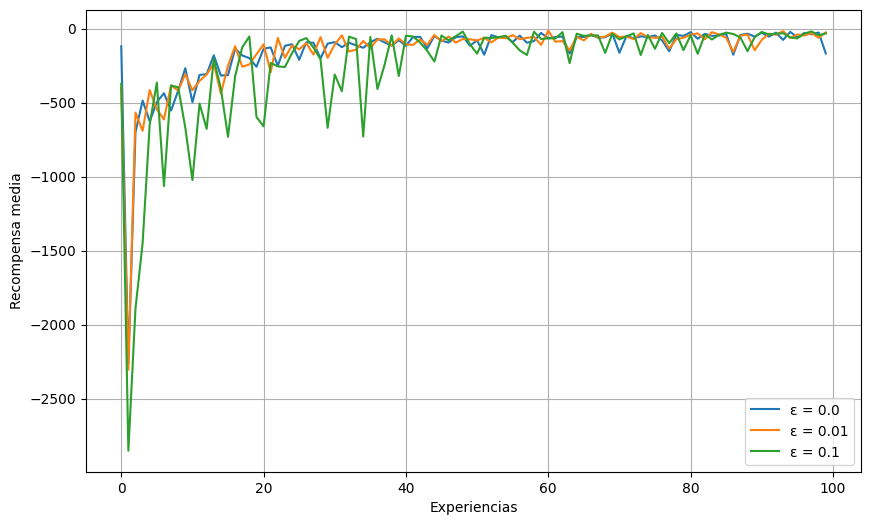

In [8]:
epsilons = [0.0, 0.01, 0.1]

# Ejecutar y graficar
plt.figure(figsize=(10, 6))

for eps in epsilons:
    Q, rewards = optimistic_q_learning(env, episodes=100, epsilon=eps)
    plt.plot(rewards, label=f'Œµ = {eps}')

plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.legend()
plt.grid(True)
plt.show()

## Selecci√≥n de acciones con intervalo de confianza

In [9]:
def ucb_q_learning(env, episodes=500, alpha=0.1, gamma=0.99, c=1.0):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            ucb_values = Q[state] + c * np.sqrt(np.log(ep + 1) / (N[state] + 1e-5))
            action = np.argmax(ucb_values)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            N[state, action] += 1
            if done:
                target = reward
            else:
                target = reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (target - Q[state, action])
            total_reward += reward
            state = next_state

        rewards.append(total_reward)
    return Q, rewards


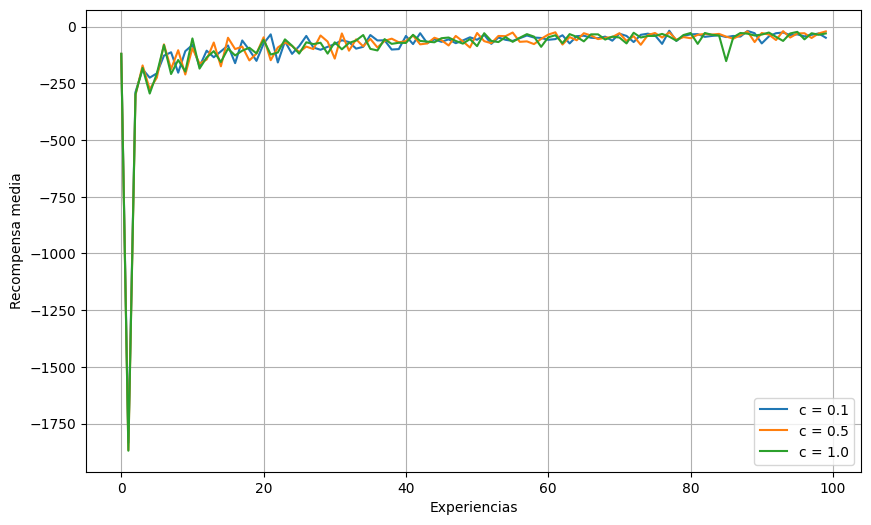

In [10]:
c_values = [0.1, 0.5, 1.0]

# Ejecutar y graficar
plt.figure(figsize=(10, 6))

for c in c_values:
    Q, rewards = ucb_q_learning(env, episodes=100, c=c)
    plt.plot(rewards, label=f'c = {c}')

plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.legend()
plt.grid(True)
plt.show()

## Algoritmos de Gradiente

In [11]:
def softmax(x, tau=1.0):
    x = x - np.max(x)
    exp_x = np.exp(x / tau)
    return exp_x / np.sum(exp_x)

def softmax_q_learning(env, episodes=500, alpha=0.1, gamma=0.99, tau=1.0):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            probs = softmax(Q[state], tau)
            action = np.random.choice(np.arange(env.action_space.n), p=probs)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                target = reward
            else:
                target = reward + gamma * np.max(Q[next_state])
            
            Q[state, action] += alpha * (target - Q[state, action])
            total_reward += reward
            state = next_state

        rewards.append(total_reward)
    return Q, rewards

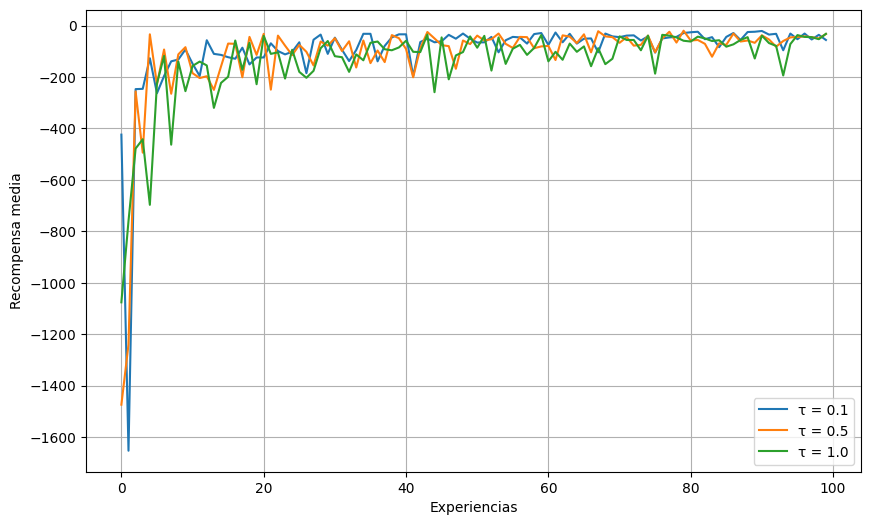

In [12]:
# Para Softmax usas diferentes valores de 'tau' (temperatura) en lugar de 'c'
tau_values = [0.1, 0.5, 1.0]

# Ejecutar y graficar
plt.figure(figsize=(10, 6))

for tau in tau_values:
    Q, rewards = softmax_q_learning(env, episodes=100, tau=tau)
    plt.plot(rewards, label=f'œÑ = {tau}')

plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.legend()
plt.grid(True)
plt.show()

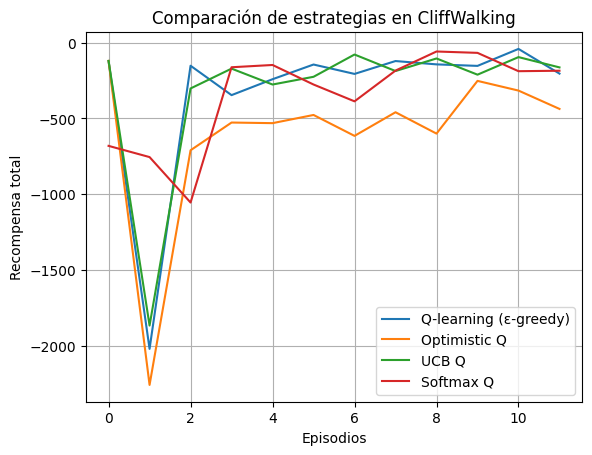

In [13]:
_, r_base = q_learning(env, episodes=12, epsilon=0.01)
_, r_opt = optimistic_q_learning(env, episodes=12, epsilon=0.01)
_, r_ucb = ucb_q_learning(env, episodes=12, c=0.5)
_, r_soft = softmax_q_learning(env, episodes=12, tau=0.5)


plt.plot(r_base, label="Q-learning (Œµ-greedy)")
plt.plot(r_opt, label="Optimistic Q")
plt.plot(r_ucb, label="UCB Q")
plt.plot(r_soft, label="Softmax Q")
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Comparaci√≥n de estrategias en CliffWalking")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import time

print("üéÆ Entrenando agente...")
Q_trained, training_rewards = q_learning(env, episodes=500, epsilon=0.01)
print(f"‚úÖ Entrenamiento completado! Recompensa final: {np.mean(training_rewards[-50:]):.2f}")

def visualize_agent_playing(env, Q, num_games=3, delay=1.0):
    """
    Visualiza al agente jugando paso a paso
    """
    actions_names = ['‚Üë Arriba', '‚Üí Derecha', '‚Üì Abajo', '‚Üê Izquierda']
    
    for game in range(num_games):
        print(f"\n{'='*50}")
        print(f"üéÆ JUEGO {game + 1}")
        print(f"{'='*50}")
        
        state, _ = env.reset()
        done = False
        total_reward = 0
        step = 0
        
        # Crear representaci√≥n visual del grid 4x12
        def print_grid(current_state):
            grid = [['.' for _ in range(12)] for _ in range(4)]
            
            # Marcar precipicio (estados 37-46)
            for i in range(37, 47):
                row = i // 12
                col = i % 12
                grid[row][col] = 'üíÄ'
            
            # Marcar inicio (estado 36)
            row, col = 3, 0
            grid[row][col] = 'üè†'
            
            # Marcar objetivo (estado 47)
            row, col = 3, 11
            grid[row][col] = 'üéØ'
            
            # Marcar posici√≥n actual del agente
            row = current_state // 12
            col = current_state % 12
            if current_state not in [36, 47] and not (37 <= current_state <= 46):
                grid[row][col] = 'ü§ñ'
            
            # Imprimir grid
            print("\n   0123456789AB")  # Columnas
            for i, row in enumerate(grid):
                print(f"{i}  {''.join(row)}")
            print()
        
        while not done:
            # Mostrar estado actual
            print(f"\n‚è∞ Paso {step + 1}")
            print(f"üìç Estado actual: {state}")
            print_grid(state)
            
            # Mostrar valores Q para este estado
            q_values = Q[state]
            print("üß† Valores Q del agente:")
            for i, (action_name, q_val) in enumerate(zip(actions_names, q_values)):
                marker = "üëâ" if i == np.argmax(q_values) else "  "
                print(f"   {marker} {action_name}: {q_val:.3f}")
            
            
            action = np.argmax(Q[state])
            chosen_action = actions_names[action]
            
            print(f"\nüéØ Agente elige: {chosen_action}")
            
            # Ejecutar acci√≥n
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            print(f"üèÜ Recompensa: {reward}")
            print(f"‚û°Ô∏è  Nuevo estado: {next_state}")
            
            # An√°lisis de la decisi√≥n
            if reward == -100:
                print("üí• ¬°CAY√ì AL PRECIPICIO! Regresa al inicio.")
            elif terminated and reward == -1:
                print("üéâ ¬°LLEG√ì AL OBJETIVO! Episodio completado.")
            else:
                print("‚úÖ Paso normal, contin√∫a...")
            
            total_reward += reward
            step += 1
            state = next_state
            
            # Pausa para visualizaci√≥n
            time.sleep(delay)
            
            # Limpiar pantalla (opcional)
            # os.system('cls' if os.name == 'nt' else 'clear')
        
        print(f"\nüèÅ RESULTADO DEL JUEGO {game + 1}:")
        print(f"   Total pasos: {step}")
        print(f"   Recompensa total: {total_reward}")
        print(f"   {'üéâ √âXITO' if total_reward >= -20 else 'üí• FALL√ì'}")
        
        input("\n‚è∏Ô∏è  Presiona ENTER para el siguiente juego...")

def analyze_learned_policy(env, Q):
    """
    Analiza la pol√≠tica aprendida estado por estado
    """
    actions_names = ['‚Üë', '‚Üí', '‚Üì', '‚Üê']
    print(f"\n{'='*60}")
    print("üß† AN√ÅLISIS DE LA POL√çTICA APRENDIDA")
    print(f"{'='*60}")
    
    # Crear mapa de pol√≠tica
    policy_grid = [['?' for _ in range(12)] for _ in range(4)]
    
    for state in range(env.observation_space.n):
        row = state // 12
        col = state % 12
        best_action = np.argmax(Q[state])
        
        # Estados especiales
        if state == 36:  # Inicio
            policy_grid[row][col] = 'üè†'
        elif state == 47:  # Objetivo
            policy_grid[row][col] = 'üéØ'
        elif 37 <= state <= 46:  # Precipicio
            policy_grid[row][col] = 'üíÄ'
        else:
            policy_grid[row][col] = actions_names[best_action]
    
    print("\nMapa de la pol√≠tica (acci√≥n preferida en cada estado):")
    print("üè†=Inicio, üéØ=Objetivo, üíÄ=Precipicio")
    print("\n   0123456789AB")
    for i, row in enumerate(policy_grid):
        print(f"{i}  {''.join(f'{cell:>2}' for cell in row)}")

# 3. USAR LAS FUNCIONES CON TU AGENTE ENTRENADO
print("üé¨ Visualizando agente entrenado jugando...")

# Primero analizar la pol√≠tica
analyze_learned_policy(env, Q_trained)

# Luego ver al agente jugando
visualize_agent_playing(env, Q_trained, num_games=3, delay=1.5)  

üéÆ Entrenando agente...
‚úÖ Entrenamiento completado! Recompensa final: -13.24
üé¨ Visualizando agente entrenado jugando...

üß† AN√ÅLISIS DE LA POL√çTICA APRENDIDA

Mapa de la pol√≠tica (acci√≥n preferida en cada estado):
üè†=Inicio, üéØ=Objetivo, üíÄ=Precipicio

   0123456789AB
0   ‚Üí ‚Üë ‚Üì ‚Üí ‚Üê ‚Üí ‚Üí ‚Üí ‚Üì ‚Üë ‚Üì ‚Üì
1   ‚Üë ‚Üí ‚Üí ‚Üê ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üì ‚Üì ‚Üì
2   ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üì
3   üè† üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üéØ

üéÆ JUEGO 1

‚è∞ Paso 1
üìç Estado actual: 36

   0123456789AB
0  ............
1  ............
2  ............
3  üè†üíÄüíÄüíÄüíÄüíÄüíÄüíÄüíÄüíÄüíÄüéØ

üß† Valores Q del agente:
   üëâ ‚Üë Arriba: -12.248
      ‚Üí Derecha: -44.700
      ‚Üì Abajo: -12.267
      ‚Üê Izquierda: -12.282

üéØ Agente elige: ‚Üë Arriba
üèÜ Recompensa: -1
‚û°Ô∏è  Nuevo estado: 24
‚úÖ Paso normal, contin√∫a...

‚è∞ Paso 2
üìç Estado actual: 24

   0123456789AB
0  ............
1  ............

In [ ]:
# SARSA: Algoritmo incremental
def sarsa(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        # Selecciona acci√≥n inicial
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Selecciona pr√≥xima acci√≥n (SARSA: on-policy)
            if not done:
                if np.random.rand() < epsilon:
                    next_action = env.action_space.sample()
                else:
                    next_action = np.argmax(Q[next_state])
                target = reward + gamma * Q[next_state, next_action]
            else:
                next_action = None
                target = reward

            Q[state, action] += alpha * (target - Q[state, action])
            total_reward += reward
            state = next_state
            action = next_action

        rewards.append(total_reward)
    return Q, rewards

In [ ]:
# Comparativa Q-learning vs SARSA
eps = 0.01
episodes = 100

Q_q, rewards_q = q_learning(env, episodes=episodes, epsilon=eps)
Q_sarsa, rewards_sarsa = sarsa(env, episodes=episodes, epsilon=eps)

plt.figure(figsize=(10, 6))
plt.plot(rewards_q, label="Q-learning")
plt.plot(rewards_sarsa, label="SARSA")
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Comparativa Q-learning vs SARSA en CliffWalking")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'q_learning' is not defined

In [ ]:
# Entrena SARSA para visualizar
Q_sarsa_trained, training_rewards_sarsa = sarsa(env, episodes=500, epsilon=0.01)
print(f"‚úÖ Entrenamiento SARSA completado! Recompensa final: {np.mean(training_rewards_sarsa[-50:]):.2f}")

print("üé¨ Visualizando agente SARSA entrenado jugando...")
analyze_learned_policy(env, Q_sarsa_trained)
visualize_agent_playing(env, Q_sarsa_trained, num_games=3, delay=1.5)

‚úÖ Entrenamiento SARSA completado! Recompensa final: -16.04
üé¨ Visualizando agente SARSA entrenado jugando...

üß† AN√ÅLISIS DE LA POL√çTICA APRENDIDA

Mapa de la pol√≠tica (acci√≥n preferida en cada estado):
üè†=Inicio, üéØ=Objetivo, üíÄ=Precipicio

   0123456789AB
0   ‚Üë ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üì ‚Üí ‚Üí ‚Üì ‚Üì ‚Üì
1   ‚Üí ‚Üì ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üí ‚Üì
2   ‚Üë ‚Üí ‚Üë ‚Üí ‚Üí ‚Üí ‚Üë ‚Üí ‚Üí ‚Üí ‚Üí ‚Üì
3   üè† üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üíÄ üéØ

üéÆ JUEGO 1

‚è∞ Paso 1
üìç Estado actual: 36

   0123456789AB
0  ............
1  ............
2  ............
3  üè†üíÄüíÄüíÄüíÄüíÄüíÄüíÄüíÄüíÄüíÄüéØ

üß† Valores Q del agente:
   üëâ ‚Üë Arriba: -13.690
      ‚Üí Derecha: -28.399
      ‚Üì Abajo: -13.803
      ‚Üê Izquierda: -13.765

üéØ Agente elige: ‚Üë Arriba
üèÜ Recompensa: -1
‚û°Ô∏è  Nuevo estado: 24
‚úÖ Paso normal, contin√∫a...

‚è∞ Paso 2
üìç Estado actual: 24

   0123456789AB
0  ............
1  ............
2  ü§ñ......